# Travel Audience Task

In [0]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from ggplot import *
from IPython.display import display, HTML

In [0]:
log_data = pd.read_csv('logs.csv')
log_data.describe()

,uuid,ts,useragent,hashed_ip
count,669491,669491,669473,669491
unique,257354,561881,17664,270797
top,58360C618E66720D851BCD72D41B2746,2017-07-16 12:14:44,Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...,010BB6D747D7
freq,923,13,52544,801


From the summary, we get basic idea about the number of unique users (257354) and uuid (58360C618E66720D851BCD72D41B2746)) with the highest event (923)

## Users' event distribution

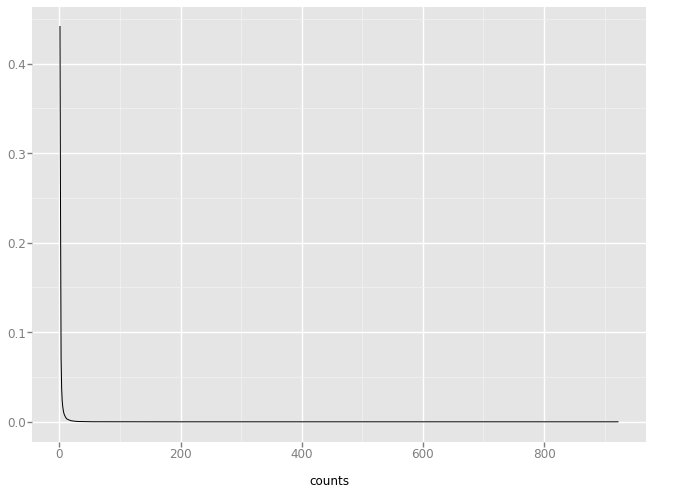

<ggplot: (8744390203605)>

In [0]:
user_dist = log_data['uuid'].value_counts().reset_index()
user_dist.columns = ['uuid', 'counts']
ggplot(user_dist, aes(x = 'counts')) + geom_density()

### Quantile values

In [0]:
user_dist.counts.quantile([.1, .25, .5, .7, .8, .9])

0.10    1.0
0.25    1.0
0.50    1.0
0.70    1.0
0.80    2.0
0.90    5.0
Name: counts, dtype: float64

The users's event distribution is heavily skewed. Around 70% of users have only 1 event associated with them, and around 90% has less than or equal to 5 events. For the 10% of users who have more than 5 events in a month, on an average such user has at least an event per week (considering 4 weeks in a month). 

## 1. Highly active users' distribution
We define a highly active user as someone who has at least 5 events in a month.

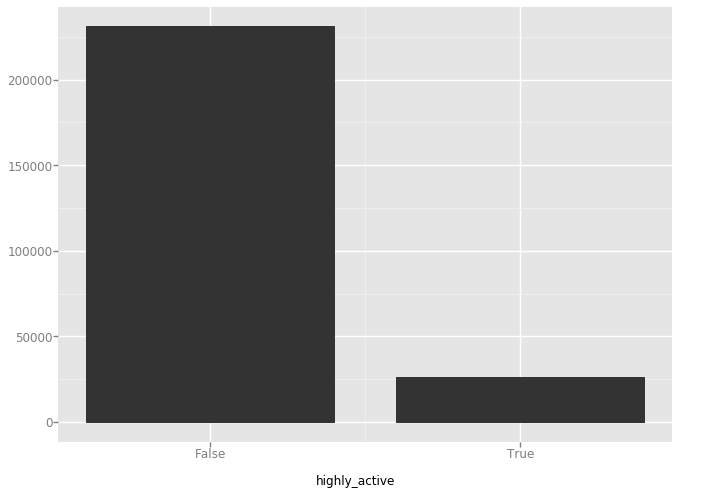

<ggplot: (8744387940681)>

In [0]:
user_dist['highly_active'] = user_dist.counts >= 5
ggplot(user_dist, aes(x = 'highly_active')) + geom_bar()

In [0]:
def split_timestamp(df):
    """Modifies df in-place to create date, weekday, and hour
    from the timestamp column

    Args:
        df (pandas DataFrame object): pandas dataframe with log data.

    Returns: In-place modified DataFrame with 3 extra columns.
    """
    df['ts'] = pd.to_datetime(df['ts'])
    df['date'] = df['ts'].dt.date
    df['weekday'] = df['ts'].dt.weekday_name
    df['weekday_numeric'] = df['ts'].dt.weekday
    df['hour'] = df['ts'].dt.hour
    df['day'] = df['ts'].dt.day
    df.drop('ts', axis=1, inplace=True)
split_timestamp(log_data)

## 2. Multiple days
A user who has events from more than 1 day, which also implies a person who has more than at least 2 events.

,index,multiple_days
0,False,86.740055
1,True,13.259945


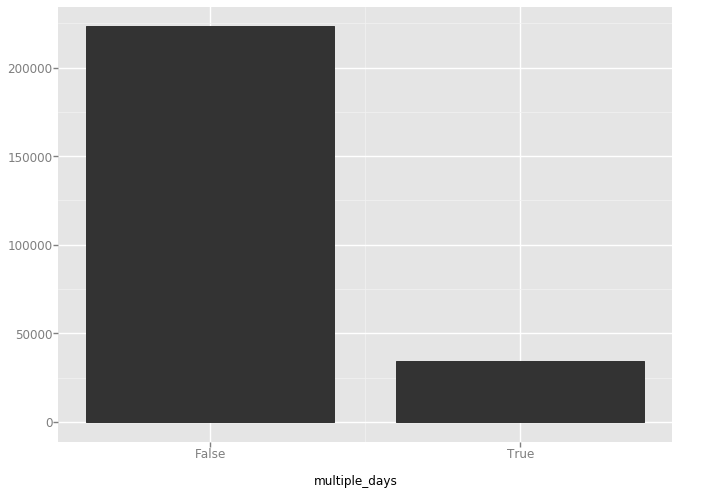

<ggplot: (8744375023489)>

In [0]:
day_users = log_data[['uuid', 'weekday_numeric']].groupby(
    ['uuid'], as_index=False).agg({'weekday_numeric':lambda x: len(x.unique())})
day_users['multiple_days'] = day_users.weekday_numeric > 1
md_dist = day_users['multiple_days'].value_counts().reset_index()
md_dist['multiple_days'] = md_dist.multiple_days*100/md_dist.multiple_days.sum()
display(HTML(md_dist.to_html()))
ggplot(day_users, aes(x = 'multiple_days')) + geom_bar()

## 3. Weekday biz
A user who is active during weekdays between 9 to 18 hours (Standard working hours 9 to 17, plus 1 hour lunch break).

,index,weekday_biz
0,False,58.566135
1,True,41.433865


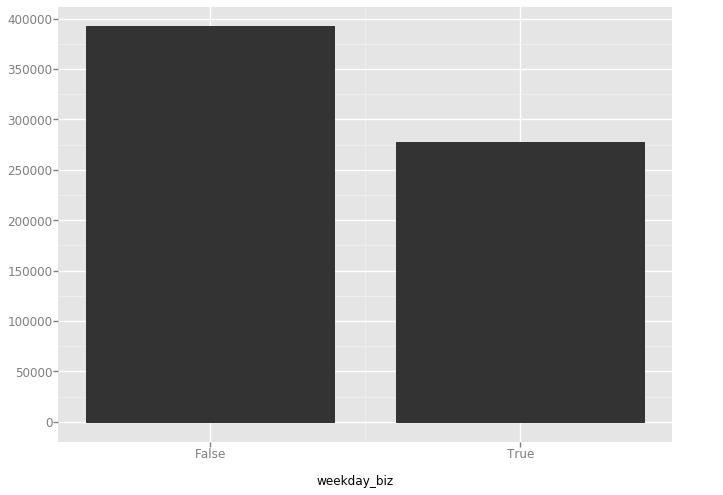

<ggplot: (8744375023497)>

In [0]:
log_data['weekday_biz'] = ((log_data.weekday != "Sunday") & (log_data.weekday != "Saturday") & 
                             (log_data.hour >= 9) & (log_data.hour <= 18))
wd_dist = log_data['weekday_biz'].value_counts().reset_index()
wd_dist['weekday_biz'] = wd_dist.weekday_biz*100/wd_dist.weekday_biz.sum()
display(HTML(wd_dist.to_html()))
ggplot(log_data, aes(x = 'weekday_biz')) + geom_bar()

## Daily events distribution

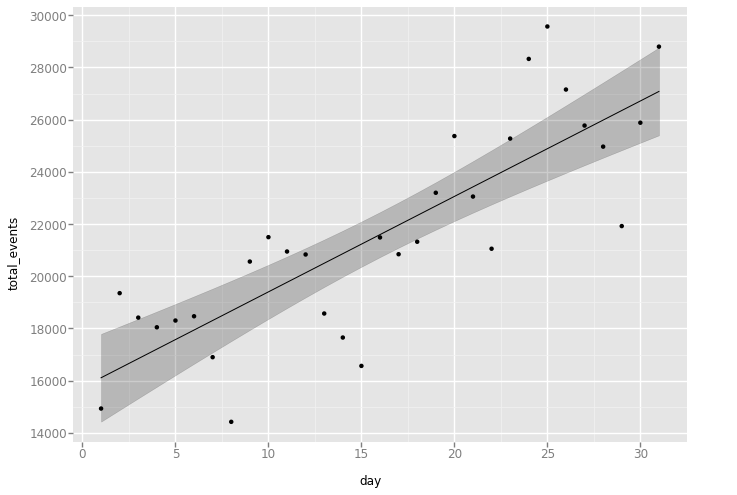

<ggplot: (8744374944081)>

In [0]:
month_day_events = log_data['day'].value_counts().reset_index() 
month_day_events.columns = ['day', 'total_events']
ggplot(month_day_events, aes(x = 'day', y = 'total_events')) + geom_point() + stat_smooth(method='lm')

We can see from the plot that there is an increasing trend in terms of number of daily events in a month.So it seems day of the month can be used as a feature, which might be predictive of clicking. 

## 4. Day of the month
The day of the month when associated with a user's event.

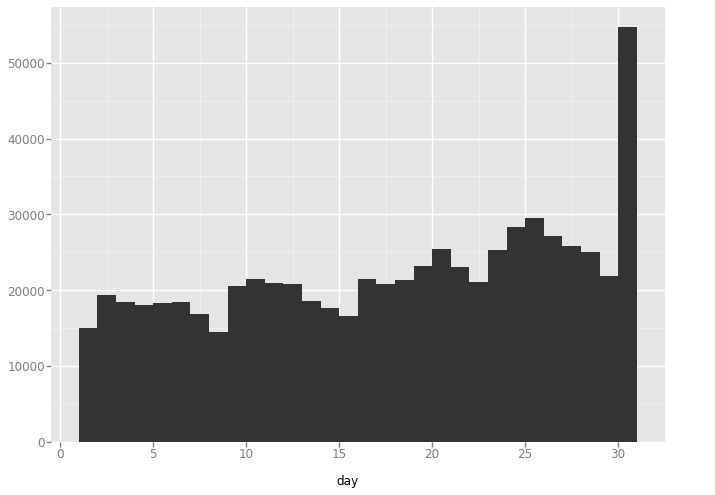

<ggplot: (8744390221305)>

In [0]:
ggplot(log_data, aes(x = 'day')) + geom_histogram(binwidth=1) 